In [1]:
%matplotlib inline

Conjuntos de datos y cargadores de datos
===================

El código para procesar muestras de datos puede complicarse y ser difícil de mantener; idealmente queremos nuestro código de conjunto de datos
para ser desacoplado de nuestro código de entrenamiento modelo para una mejor legibilidad y modularidad.
PyTorch proporciona dos primitivas de datos: ``torch.utils.data.DataLoader`` y ``torch.utils.data.Dataset``
que le permiten utilizar conjuntos de datos precargados, así como sus propios datos.
``Dataset`` almacena las muestras y sus etiquetas correspondientes, y ``DataLoader`` envuelve un iterable alrededor
el ``Conjunto de datos`` para permitir un fácil acceso a las muestras.

Las bibliotecas de dominio de PyTorch proporcionan una serie de conjuntos de datos precargados (como FashionMNIST) que
subclase ``torch.utils.data.Dataset`` e implemente funciones específicas para los datos particulares.
Se pueden usar para crear prototipos y comparar su modelo. Puedes encontrarlos
aquí: `Conjuntos de datos de imagen <https://pytorch.org/vision/stable/datasets.html>`_,
`Conjuntos de datos de texto <https://pytorch.org/text/stable/datasets.html>`_, y
`Conjuntos de datos de audio <https://pytorch.org/audio/stable/datasets.html>`_



Cargando un conjunto de datos
-------------------

Este es un ejemplo de cómo cargar el conjunto de datos `Fashion-MNIST <https://research.zalando.com/project/fashion_mnist/fashion_mnist/>`_ de TorchVision.
Fashion-MNIST es un conjunto de datos de imágenes de artículos de Zalando que consta de 60 000 ejemplos de entrenamiento y 10 000 ejemplos de prueba.
Cada ejemplo comprende una imagen en escala de grises de 28 × 28 y una etiqueta asociada de una de las 10 clases.

Cargamos el `Conjunto de datos FashionMNIST <https://pytorch.org/vision/stable/datasets.html#fashion-mnist>`_ con los siguientes parámetros:
  - ``raíz`` es la ruta donde se almacenan los datos del tren/prueba,
  - ``train`` especifica un conjunto de datos de entrenamiento o prueba,
  - ``download=True`` descarga los datos de Internet si no están disponibles en ``root``.
  - ``transform`` y ``target_transform`` especifican las transformaciones de características y etiquetas


In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Iterando y visualizando el conjunto de datos
-----------------

Podemos indexar ``Conjuntos de datos`` manualmente como una lista: ``training_data[index]``.
Usamos ``matplotlib`` para visualizar algunas muestras en nuestros datos de entrenamiento.

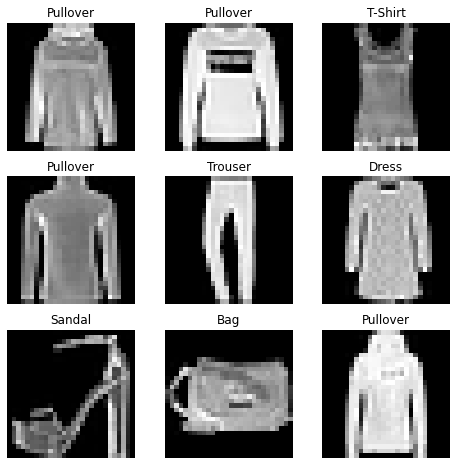

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

..
 .. figure:: /_static/img/basics/fashion_mnist.png
   :alt: fashion_mnist



--------------




Creación de un conjunto de datos personalizado para sus archivos
--------------------------------------------------

Una clase de conjunto de datos personalizada debe implementar tres funciones: `__init__`, `__len__` y `__getitem__`.
Echa un vistazo a esta implementación; las imágenes de FashionMNIST se almacenan
en un directorio ``img_dir``, y sus etiquetas se almacenan por separado en un archivo CSV ``annotations_file``.

En las siguientes secciones, desglosaremos lo que sucede en cada una de estas funciones.

In [4]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

__init__
^^^^^^^^^^^^^^^^^^^^

La función __init__ se ejecuta una vez al instanciar el objeto Dataset. Inicializamos
el directorio que contiene las imágenes, el archivo de anotaciones y ambas transformaciones (cubiertas
con más detalle en la siguiente sección).

El archivo etiquetas.csv se parece a: ::

    tshirt1.jpg, 0
    tshirt2.jpg, 0
    ......
    ankleboot999.jpg, 9



In [5]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

__len__
^^^^^^^^^^^^^^^^^^^^

La función __len__ devuelve el número de muestras en nuestro conjunto de datos.

Ejemplo:

In [6]:
def __len__(self):
    return len(self.img_labels)

__obtiene el objeto__
 ^^^^^^^^^^^^^^^^^^^^

 La función __getitem__ carga y devuelve una muestra del conjunto de datos en el índice dado ``idx``.
 Basado en el índice, identifica la ubicación de la imagen en el disco, la convierte en un tensor usando ``read_image``, recupera la
 etiqueta correspondiente de los datos csv en ``self.img_labels``, llama a las funciones de transformación en ellos (si corresponde) y devuelve la
 imagen del tensor y etiqueta correspondiente en una tupla.



In [7]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

--------------




Preparando sus datos para el entrenamiento con DataLoaders
-------------------------------------------------
El ``Conjunto de datos`` recupera las características de nuestro conjunto de datos y etiqueta una muestra a la vez. Mientras entrenamos un modelo, normalmente queremos
pasar muestras en "minilotes", reorganizar los datos en cada época para reducir el sobreajuste del modelo y utilizar el ``multiprocesamiento`` de Python para
acelerar la recuperación de datos.

``DataLoader`` es un iterable que abstrae esta complejidad para nosotros en una API fácil.

In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Iterar a través del DataLoader
--------------------------

Hemos cargado ese conjunto de datos en ``DataLoader`` y podemos iterar a través del conjunto de datos según sea necesario.
Cada iteración a continuación devuelve un lote de ``train_features`` y ``train_labels`` (que contienen ``batch_size=64`` características y etiquetas respectivamente).
Debido a que especificamos ``shuffle=True``, después de iterar sobre todos los lotes, los datos se mezclan (para un control más detallado sobre
el orden de carga de datos, eche un vistazo a `Samplers <https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler>`_).

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


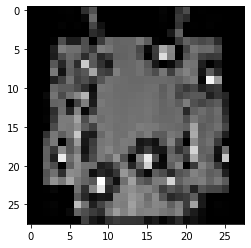

Label: 6


In [9]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

Gracias A:
----------------
Documentacion oficial de pytorch: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

Traducido por: Mi :)

--------------


